# Augmentations

In [1]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load annotations
with open('train_annotations.json', 'r') as f:
    data = json.load(f)

print(f"Total images to process: {len(data['images'])}")

Total images to process: 150


In [2]:
# Count classes
individual_tree_count = 0
group_of_trees_count = 0

for image_data in data['images']:
    for annotation in image_data['annotations']:
        if annotation['class'] == 'individual_tree':
            individual_tree_count += 1
        elif annotation['class'] == 'group_of_trees':
            group_of_trees_count += 1

print(f"Dataset Statistics:")
print(f"Individual Trees: {individual_tree_count}")
print(f"Groups of Trees: {group_of_trees_count}")
print(f"Total Annotations: {individual_tree_count + group_of_trees_count}")

Dataset Statistics:
Individual Trees: 34603
Groups of Trees: 4309
Total Annotations: 38912


In [3]:
import albumentations as A
from albumentations.core.composition import Compose
import cv2
import copy

# Install albumentations if not available
# !pip install albumentations

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>
  data = fetch_version_info()


In [4]:
# Define individual augmentations with proper parameters
def get_augmentations(image_name):
    """Returns list of augmentations based on image resolution"""
    
    h_flip = A.HorizontalFlip(p=1.0)
    v_flip = A.VerticalFlip(p=1.0)
    rotate = A.Rotate(limit=(15, 15), border_mode=cv2.BORDER_CONSTANT, p=1.0)
    
    # Zoom in: crop center portion and resize back to original size
    zoom_in = A.Compose([
        A.CenterCrop(height=768, width=768, p=1.0),  # Crop 75% of 1024x1024
        A.Resize(height=1024, width=1024, p=1.0)
    ])
    
    contrast = A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.2, 0.5), p=1.0)
    saturation = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30, val_shift_limit=0, p=1.0)
    noise = A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=1.0)
    
    # Base augmentations for all images
    augs = [
        ('horizontal_flip', h_flip),
        ('vertical_flip', v_flip),
        ('rotate_15deg', rotate),
        ('zoom_in', zoom_in),
        ('contrast', contrast),
        ('saturation', saturation),
        ('gaussian_noise', noise)
    ]
    
    # Add zoom out for 10cm and 20cm images
    if '10cm' in image_name or '20cm' in image_name:
        # Zoom out: resize smaller then pad back to original size
        zoom_out = A.Compose([
            A.Resize(height=768, width=768, p=1.0),  # Shrink to 75%
            A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=cv2.BORDER_CONSTANT, p=1.0)
        ])
        augs.append(('zoom_out', zoom_out))
    
    return augs

print("Augmentation pipelines defined successfully!")

Augmentation pipelines defined successfully!


In [5]:
def check_polygon_visibility(segmentation, image_shape, dropout_mask=None):
    """Check if polygon is visible and valid"""
    if len(segmentation) < 6:  # Need at least 3 points
        return False
    
    points = np.array(segmentation).reshape(-1, 2)
    
    # Check if all points are within bounds
    if np.any(points[:, 0] < 0) or np.any(points[:, 0] >= image_shape[1]):
        return False
    if np.any(points[:, 1] < 0) or np.any(points[:, 1] >= image_shape[0]):
        return False
    
    # For coarse dropout, check if polygon overlaps significantly with dropped regions
    if dropout_mask is not None:
        # Create a mask for this polygon
        poly_mask = np.zeros(image_shape[:2], dtype=np.uint8)
        points_int = points.astype(np.int32)
        cv2.fillPoly(poly_mask, [points_int], 255)
        
        # Check overlap with dropped regions (black areas in dropout_mask)
        dropped_regions = dropout_mask < 10  # Binary mask of dropped regions
        overlap = np.logical_and(poly_mask > 0, dropped_regions)
        overlap_ratio = np.sum(overlap) / np.sum(poly_mask > 0) if np.sum(poly_mask > 0) > 0 else 0
        
        # If more than 50% of polygon is in dropped region, discard it
        if overlap_ratio > 0.5:
            return False
    
    return True

def apply_augmentation(image, annotations, augmentation, aug_name):
    """Apply augmentation to image and adjust annotations accordingly"""
    # Convert segmentations to keypoints format for albumentations
    all_keypoints = []
    annotation_data = []  # Store (ann_idx, original_num_points)
    
    for idx, annotation in enumerate(annotations):
        seg = annotation['segmentation']
        num_points = len(seg) // 2
        
        for i in range(0, len(seg), 2):
            # Clip coordinates to valid range [0, 1023] to avoid boundary errors
            x = min(seg[i], 1023.999)
            y = min(seg[i+1], 1023.999)
            all_keypoints.append([x, y])
        
        annotation_data.append((idx, num_points))
    
    # Apply augmentation with keypoints
    transform = A.Compose(
        [augmentation],
        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)  # Keep all keypoints
    )
    
    transformed = transform(image=image, keypoints=all_keypoints)
    transformed_image = transformed['image']
    transformed_keypoints = transformed['keypoints']
    
    # For coarse dropout, create a grayscale version to detect dropped regions
    dropout_mask = None
    if aug_name == 'coarse_dropout':
        dropout_mask = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2GRAY)
    
    # Reconstruct annotations with transformed coordinates
    new_annotations = []
    keypoint_offset = 0
    
    for ann_idx, num_points in annotation_data:
        annotation = annotations[ann_idx]
        new_ann = copy.deepcopy(annotation)
        new_ann['segmentation'] = []
        
        # Extract the keypoints for this annotation
        ann_keypoints = transformed_keypoints[keypoint_offset:keypoint_offset + num_points]
        keypoint_offset += num_points
        
        # Check if we have all the points (none were removed)
        if len(ann_keypoints) != num_points:
            # Some keypoints were removed - skip this annotation
            continue
        
        # Build segmentation from transformed keypoints
        valid_polygon = True
        for x, y in ann_keypoints:
            # Check if point is within bounds
            if x < 0 or x >= transformed_image.shape[1] or y < 0 or y >= transformed_image.shape[0]:
                valid_polygon = False
                break
            new_ann['segmentation'].extend([float(x), float(y)])
        
        # Only add if polygon is valid and visible
        if valid_polygon and check_polygon_visibility(new_ann['segmentation'], transformed_image.shape, dropout_mask):
            new_annotations.append(new_ann)
    
    return transformed_image, new_annotations

print("Helper functions defined successfully!")


Helper functions defined successfully!


In [6]:
# Create augmented dataset
augmented_folder = 'augmented_dataset'
augmented_images_folder = os.path.join(augmented_folder, 'images')
os.makedirs(augmented_images_folder, exist_ok=True)

# Initialize new annotations structure
augmented_data = {
    'images': []
}

print(f"Created augmented dataset folder: {augmented_folder}")
print("Starting augmentation process...")

Created augmented dataset folder: augmented_dataset
Starting augmentation process...


In [7]:
# Process each image with augmentations
total_images = len(data['images'])
processed_count = 0

for image_data in data['images']:
    file_name = image_data['file_name']
    image_path = os.path.join('train_images', file_name)
    
    # Load image using OpenCV (for albumentations compatibility)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Save original image
    original_name = file_name.replace('.tif', '_original.png')
    original_path = os.path.join(augmented_images_folder, original_name)
    cv2.imwrite(original_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
    # Add original to augmented data
    original_data = copy.deepcopy(image_data)
    original_data['file_name'] = original_name
    augmented_data['images'].append(original_data)
    
    # Get augmentations for this image
    augmentations_to_apply = get_augmentations(file_name)
    
    # Apply each augmentation
    for aug_name, augmentation in augmentations_to_apply:
        try:
            # Apply augmentation
            augmented_image, augmented_annotations = apply_augmentation(
                image.copy(), 
                image_data['annotations'],
                augmentation,
                aug_name
            )
            
            # Create new filename
            base_name = file_name.replace('.tif', '')
            aug_file_name = f"{base_name}_{aug_name}.png"
            aug_path = os.path.join(augmented_images_folder, aug_file_name)
            
            # Save augmented image
            cv2.imwrite(aug_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
            
            # Create new annotation entry
            aug_data = {
                'file_name': aug_file_name,
                'width': image_data['width'],
                'height': image_data['height'],
                'cm_resolution': image_data['cm_resolution'],
                'scene_type': image_data['scene_type'],
                'annotations': augmented_annotations,
                'augmentation': aug_name,
                'original_file': file_name
            }
            augmented_data['images'].append(aug_data)
            
        except Exception as e:
            print(f"Error augmenting {file_name} with {aug_name}: {str(e)}")
    
    processed_count += 1
    if processed_count % 10 == 0:
        print(f"Processed {processed_count}/{total_images} images")

print(f"\nCompleted! Total images created: {len(augmented_data['images'])}")
print(f"Original images: {total_images}")
print(f"Augmented images: {len(augmented_data['images']) - total_images}")

/var/folders/fr/x19nqp_n1kj5j4zdgrxschk00000gn/T/ipykernel_15524/343524476.py:17: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  noise = A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=1.0)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


Processed 10/150 images
Processed 20/150 images
Processed 30/150 images
Processed 40/150 images
Processed 50/150 images
Processed 60/150 images
Processed 70/150 images
Processed 80/150 images
Processed 90/150 images
Processed 100/150 images
Processed 110/150 images
Processed 120/150 images
Processed 130/150 images
Processed 140/150 images
Processed 150/150 images

Completed! Total images created: 1275
Original images: 150
Augmented images: 1125


In [8]:
# Save augmented annotations to JSON file
augmented_annotations_path = os.path.join(augmented_folder, 'augmented_annotations.json')
with open(augmented_annotations_path, 'w') as f:
    json.dump(augmented_data, f, indent=4)

print(f"Augmented annotations saved to: {augmented_annotations_path}")

# Calculate new class distribution
individual_tree_count_aug = 0
group_of_trees_count_aug = 0

for image_data in augmented_data['images']:
    for annotation in image_data['annotations']:
        if annotation['class'] == 'individual_tree':
            individual_tree_count_aug += 1
        elif annotation['class'] == 'group_of_trees':
            group_of_trees_count_aug += 1

print(f"\n=== Augmented Dataset Statistics ===")
print(f"Total images: {len(augmented_data['images'])}")
print(f"Individual Trees: {individual_tree_count_aug}")
print(f"Groups of Trees: {group_of_trees_count_aug}")
print(f"Total Annotations: {individual_tree_count_aug + group_of_trees_count_aug}")
print(f"\nImprovement:")
print(f"Individual Trees: {individual_tree_count} → {individual_tree_count_aug} ({individual_tree_count_aug/individual_tree_count:.1f}x)")
print(f"Groups of Trees: {group_of_trees_count} → {group_of_trees_count_aug} ({group_of_trees_count_aug/group_of_trees_count:.1f}x)")

Augmented annotations saved to: augmented_dataset/augmented_annotations.json

=== Augmented Dataset Statistics ===
Total images: 1275
Individual Trees: 264854
Groups of Trees: 31514
Total Annotations: 296368

Improvement:
Individual Trees: 34603 → 264854 (7.7x)
Groups of Trees: 4309 → 31514 (7.3x)


Selecting one example per augmentation type...
Found 8 augmentation types: contrast, gaussian_noise, horizontal_flip, rotate_15deg, saturation, vertical_flip, zoom_in, zoom_out


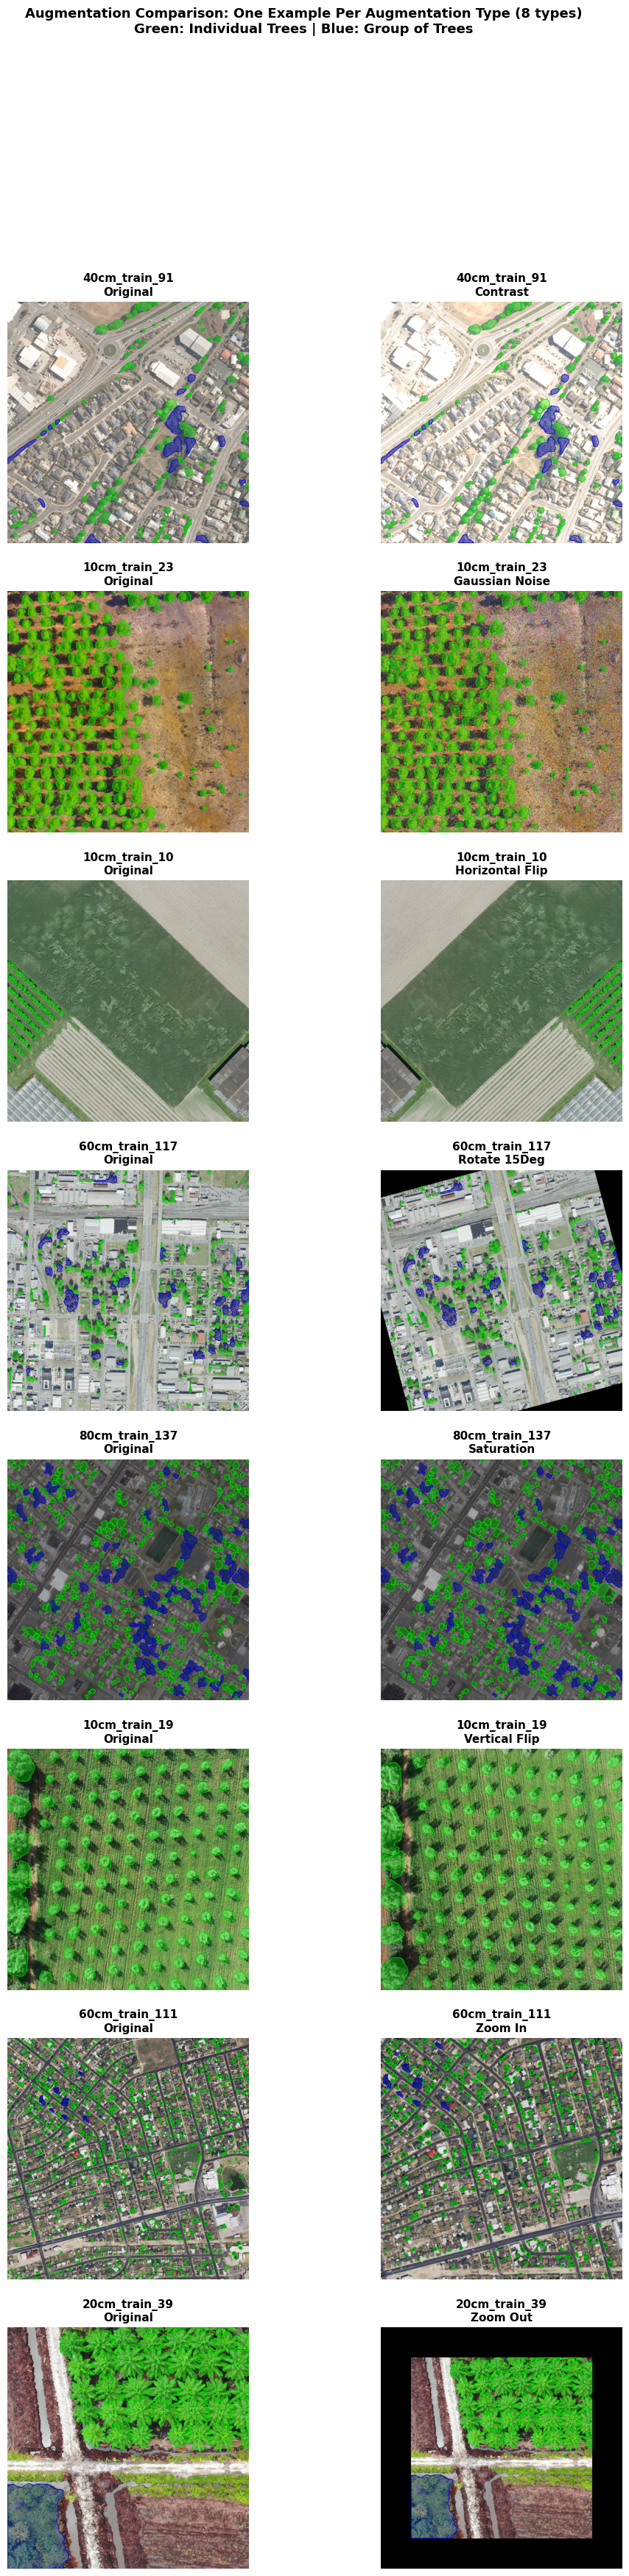

✓ Visualization complete!
  Displaying 8 pairs (one per augmentation type)
  Left column: Original images
  Right column: Augmented images
  Green masks: Individual Trees
  Blue masks: Group of Trees


In [9]:
# Visualize one example of each augmentation type (comparing with original)
import random

print("Selecting one example per augmentation type...")

# Get all augmentation types (excluding 'original')
aug_types = set()
for img in augmented_data['images']:
    aug = img.get('augmentation')
    if aug and aug != 'original':
        aug_types.add(aug)

aug_types = sorted(list(aug_types))
print(f"Found {len(aug_types)} augmentation types: {', '.join(aug_types)}")

# Select one random example for each augmentation type
selected_images = []
for aug_type in aug_types:
    candidates = [img for img in augmented_data['images'] if img.get('augmentation') == aug_type]
    if candidates:
        selected_images.append(random.choice(candidates))

# Create a figure with 2 columns (original, augmented) and rows = number of augmentation types
num_rows = len(selected_images)
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))

# Handle case where there's only one augmentation type
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, img_data in enumerate(selected_images):
    # Find the original image
    original_file = img_data.get('original_file')
    original_data = None
    for img in augmented_data['images']:
        if img['file_name'] == original_file.replace('.tif', '_original.png'):
            original_data = img
            break
    
    # Load and display original image
    if original_data:
        orig_img_path = os.path.join(augmented_images_folder, original_data['file_name'])
        orig_img = cv2.imread(orig_img_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
        # Draw annotations on original
        orig_overlay = orig_img.copy()
        for annotation in original_data['annotations']:
            seg = annotation['segmentation']
            if len(seg) < 6:
                continue
                
            points = np.array([(int(seg[i]), int(seg[i+1])) for i in range(0, len(seg), 2)], dtype=np.int32)
            
            if annotation['class'] == 'individual_tree':
                fill_color = (0, 255, 0)
                outline_color = (0, 200, 0)
            else:
                fill_color = (0, 0, 255)
                outline_color = (0, 0, 200)
            
            cv2.fillPoly(orig_overlay, [points], fill_color)
            cv2.polylines(orig_img, [points], True, outline_color, 2)
        
        orig_img_with_masks = cv2.addWeighted(orig_overlay, 0.3, orig_img, 0.7, 0)
        
        axes[idx, 0].imshow(orig_img_with_masks)
        base_name = original_file.split('.')[0]
        axes[idx, 0].set_title(f"{base_name}\nOriginal", fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')
    
    # Load and display augmented image
    aug_img_path = os.path.join(augmented_images_folder, img_data['file_name'])
    aug_img = cv2.imread(aug_img_path)
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
    
    # Draw annotations on augmented image
    aug_overlay = aug_img.copy()
    for annotation in img_data['annotations']:
        seg = annotation['segmentation']
        if len(seg) < 6:
            continue
            
        points = np.array([(int(seg[i]), int(seg[i+1])) for i in range(0, len(seg), 2)], dtype=np.int32)
        
        if annotation['class'] == 'individual_tree':
            fill_color = (0, 255, 0)
            outline_color = (0, 200, 0)
        else:
            fill_color = (0, 0, 255)
            outline_color = (0, 0, 200)
        
        cv2.fillPoly(aug_overlay, [points], fill_color)
        cv2.polylines(aug_img, [points], True, outline_color, 2)
    
    aug_img_with_masks = cv2.addWeighted(aug_overlay, 0.3, aug_img, 0.7, 0)
    
    axes[idx, 1].imshow(aug_img_with_masks)
    aug_type = img_data.get('augmentation', 'augmented')
    axes[idx, 1].set_title(f"{base_name}\n{aug_type.replace('_', ' ').title()}", fontsize=11, fontweight='bold')
    axes[idx, 1].axis('off')

plt.suptitle(f'Augmentation Comparison: One Example Per Augmentation Type ({len(selected_images)} types)\nGreen: Individual Trees | Blue: Group of Trees', 
             fontsize=13, fontweight='bold')
plt.show()

print("✓ Visualization complete!")
print(f"  Displaying {len(selected_images)} pairs (one per augmentation type)")
print("  Left column: Original images")
print("  Right column: Augmented images")
print("  Green masks: Individual Trees")
print("  Blue masks: Group of Trees")